In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics_R
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points    = 0
Title         = 'Synthetic Regression'
FUR_Weight    = 0.3
N_consistancy = 25
consist_bound = 0.3

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.3, 0.7]


In [4]:
Title = Title + ' W:'+ str(FUR_Weight)

In [5]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Synthetic_Reg', Feature_Counts=[16,12])

#Reg_Data.df().head()

In [6]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.38910964941206905


MLPRegressor(random_state=RandomState(MT19937) at 0x29214C89840)

In [7]:
Reg_Data.Random_Forest()

0.24505681650857591


RandomForestRegressor(random_state=RandomState(MT19937) at 0x29214C89840)

In [8]:
Reg_Data.GP()

-0.011885280193792092


GaussianProcessRegressor()

In [9]:
Reg_Data.L_Regression()

0.37754351277486964


LinearRegression()

In [10]:
print(Reg_Data.get_features())

['Passive_0', 'Passive_1', 'Active_2', 'Active_3', 'Active_4', 'Active_5', 'Active_6', 'Active_7']


In [11]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [12]:
#I2nd explainer object
URM_Exp_2 = UR_Model(bbox_model           = Reg_Data.get_L_Regression(),
                     train_data           = X_train,
                     feature_names        = Reg_Data.get_features(),
                     categorical_features = Reg_Data.get_catagorical(),
                     mode                 = Reg_Data.get_mode(),
                     sampling_optimize    = "opt")



In [13]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [ 11.37857693   9.41542834  11.99277669   7.23752663  19.20019541
  17.12492584 -16.64662972   9.20825059]
Std 0:  [1.58107634 3.02401424 3.91522457 4.25169303 1.34102585 3.68400301
 4.88006698 4.55886045]


In [14]:
# Generate explantion data for Random Forest

Reg_Stats   = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std(),
                                   N_consistancy = N_consistancy)

Reg_Stats_2 = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std())


if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    consistancy = URM_Exp.Y_Consistancy(N_points = N_consistancy, std_bound = consist_bound)
    
    URM_Exp.del_1_rel()
    
    del_1_var = URM_Exp.get_del_1_variance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         consistancy   = consistancy,
                         del_1_var     = del_1_var)
    
    
    ############################################################################################
    
    URM_Exp_2.explain(X_init      = data_row.reshape(1, -1),
                      Dimension   = 'Multi D',
                      kernel_type = "Matern",
                      max_iter    = 20,
                      alpha       = "FUR_W",
                      #jitter=5,
                      interval    = 1,
                      weight      = FUR_Weight)
       
    f_predict = Reg_Data.get_L_Regression().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp_2.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    scores = URM_Exp_2.permutation_importance()
    
    Reg_Stats_2.Add_Sample(sample_scores = scores,
                           outcome       = y_test[test_instance],
                           X_row         = data_row.reshape(1, -1),
                           f_prediction  = f_predict,
                           e_prediction  = e_predict.ravel(),
                           feopt         = None)
    


INSTANCE:  0
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-13.61400398] [-1.36140040e+01  1.00000004e-05] [-13.61400398]
Acq_Data_nD
INSTANCE:  1
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[20.85851527] [2.08585153e+01 1.00000004e-05] [20.85851528]
Acq_Data_nD
INSTANCE:  2
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-8.73308646] [-8.73308647e+00  1.00000004e-05] [-8.73308647]
Acq_Data_nD
INSTANCE:  3
Acq_Data_nD
[-78.79073699] [-7.87907370e+01  1.00000004e-05] [-78.790737]
Acq_Data_nD
INSTANCE:  4
Acq_Data_nD
[-84.97853775] [-8.49785377e+01  1.00000004e-05] [-84.97853774]
Acq_Data_nD
INSTANCE:  5
Acq_Data_nD
[26.98276079] [2.69827608e+01 1.00000004e-05] [26.98276079]
Acq_Data_nD
INSTANCE:  6
Acq_Data_nD
[33.96437616] [3.39643762e+01 1.00000004e-05] [33.96437616]
Acq_Data_nD
INSTANCE:  7
Acq_Data_nD
[-54.4305767] [-5.44305767e+01  1.00000004e-05] [-54.4305767]
Acq_Data_nD
INSTANCE:  8
Acq_Data_nD
[-79.52620335] [-7.95262033e+01  1.00000004e-05] [-79.52620334]
Acq_Data_nD
INSTANCE:  9
Acq_Data_nD
[-63.51015281] [-6.35101528e+01  1.00000004e-05] [-63.51015281]
Acq_Data_nD
INSTANCE:  10
Acq_Data_nD
[6.46640166] [6.46640167e+00 1.00000004e-05] [6.46640167]
Acq_Data_nD
INSTANCE:  11
Acq_Data_nD
[122.24905492] [1.22249055e+02 1.00000004e-05] [122.24905492]
Acq_Data_nD
INSTANCE:  12
Acq_Data_nD
[-12.6785

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


INSTANCE:  13
Acq_Data_nD
[-36.40565197] [-3.64056520e+01  1.00000004e-05] [-36.40565198]
Acq_Data_nD
INSTANCE:  14
Acq_Data_nD
[53.46005405] [5.34600541e+01 1.00000004e-05] [53.46005405]
Acq_Data_nD
INSTANCE:  15
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\d

[11.37574563] [1.13757456e+01 1.00000004e-05] [11.37574562]
Acq_Data_nD
INSTANCE:  16
Acq_Data_nD
[-79.00495388] [-7.90049539e+01  1.00000004e-05] [-79.00495389]
Acq_Data_nD
INSTANCE:  17
Acq_Data_nD
[-31.31054898] [-3.13105490e+01  1.00000004e-05] [-31.31054898]
Acq_Data_nD
INSTANCE:  18
Acq_Data_nD
[34.63571432] [3.46357143e+01 1.00000004e-05] [34.63571433]
Acq_Data_nD
INSTANCE:  19
Acq_Data_nD
[-6.49354686] [-6.49354686e+00  1.00000004e-05] [-6.49354686]
Acq_Data_nD
INSTANCE:  20
Acq_Data_nD
[-1.17874] [-1.17874000e+00  1.00000004e-05] [-1.17874]
Acq_Data_nD
INSTANCE:  21
Acq_Data_nD
[79.3097224] [7.93097224e+01 1.00000004e-05] [79.3097224]
Acq_Data_nD
INSTANCE:  22
Acq_Data_nD
[26.44675385] [2.64467538e+01 1.00000004e-05] [26.44675385]
Acq_Data_nD
INSTANCE:  23
Acq_Data_nD
[-105.19459423] [-1.05194594e+02  1.00000004e-05] [-105.19459424]
Acq_Data_nD
INSTANCE:  24
Acq_Data_nD
[-63.44335596] [-6.34433560e+01  1.00000004e-05] [-63.44335596]
Acq_Data_nD
INSTANCE:  25
Acq_Data_nD
[-62.1

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[65.12084613] [6.51208461e+01 1.00000004e-05] [65.12084614]
Acq_Data_nD
INSTANCE:  28
Acq_Data_nD
[-9.51471053] [-9.51471053e+00  1.00000004e-05] [-9.51471053]
Acq_Data_nD
INSTANCE:  29
Acq_Data_nD
[-23.09935687] [-2.30993569e+01  1.00000004e-05] [-23.09935687]
Acq_Data_nD
INSTANCE:  30
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[75.74045579] [7.57404558e+01 1.00000004e-05] [75.74045578]
Acq_Data_nD
INSTANCE:  31
Acq_Data_nD
[-2.52392604] [-2.52392604e+00  1.00000004e-05] [-2.52392604]
Acq_Data_nD
INSTANCE:  32
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[1.49600851] [1.49600851e+00 1.00000004e-05] [1.49600851]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  33
Acq_Data_nD
[-71.03358861] [-7.10335886e+01  1.00000004e-05] [-71.03358861]
Acq_Data_nD
INSTANCE:  34
Acq_Data_nD
[-58.41471521] [-5.84147152e+01  1.00000004e-05] [-58.41471521]
Acq_Data_nD
INSTANCE:  35
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[21.37294929] [2.13729493e+01 1.00000004e-05] [21.37294929]
Acq_Data_nD
INSTANCE:  36
Acq_Data_nD
[42.85725435] [4.28572543e+01 1.00000004e-05] [42.85725435]
Acq_Data_nD
INSTANCE:  37
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-6.65629139] [-6.65629139e+00  1.00000004e-05] [-6.65629139]
Acq_Data_nD
INSTANCE:  38
Acq_Data_nD
[-111.1934988] [-1.11193499e+02  1.00000004e-05] [-111.1934988]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  39
Acq_Data_nD
[-21.78406459] [-2.17840646e+01  1.00000004e-05] [-21.78406459]
Acq_Data_nD
INSTANCE:  40
Acq_Data_nD
[-78.30433054] [-7.83043305e+01  1.00000004e-05] [-78.30433054]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


INSTANCE:  41
Acq_Data_nD
[20.46760233] [2.04676023e+01 1.00000004e-05] [20.46760233]
Acq_Data_nD
INSTANCE:  42
Acq_Data_nD
[-119.81043653] [-1.19810437e+02  1.00000004e-05] [-119.81043658]
Acq_Data_nD
INSTANCE:  43
Acq_Data_nD
[91.48938183] [9.14893818e+01 1.00000004e-05] [91.48938183]
Acq_Data_nD
INSTANCE:  44
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[22.29285107] [2.22928511e+01 1.00000004e-05] [22.29285107]
Acq_Data_nD
INSTANCE:  45
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\d

[7.7569814] [7.75698140e+00 1.00000004e-05] [7.7569814]
Acq_Data_nD
INSTANCE:  46
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

[44.04698349] [4.40469838e+01 9.99998931e-06] [44.04698385]
Acq_Data_nD
INSTANCE:  47
Acq_Data_nD
[19.60162511] [1.96016251e+01 1.00000004e-05] [19.60162511]
Acq_Data_nD
INSTANCE:  48
Acq_Data_nD
[-84.7260188] [-8.47260188e+01  1.00000004e-05] [-84.7260188]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  49
Acq_Data_nD
[-6.65132009] [-6.65132009e+00  1.00000004e-05] [-6.65132009]
Acq_Data_nD
INSTANCE:  50
Acq_Data_nD
[-18.42234584] [-1.84223458e+01  1.00000004e-05] [-18.42234584]
Acq_Data_nD
INSTANCE:  51
Acq_Data_nD
[63.94317139] [6.39431714e+01 1.00000004e-05] [63.9431714]
Acq_Data_nD
INSTANCE:  52
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[39.87016764] [3.98701676e+01 1.00000004e-05] [39.87016764]
Acq_Data_nD
INSTANCE:  53
Acq_Data_nD
[-20.71937406] [-2.07193741e+01  1.00000004e-05] [-20.71937406]
Acq_Data_nD
INSTANCE:  54
Acq_Data_nD
[-79.87693261] [-7.98769326e+01  1.00000004e-05] [-79.8769326]
Acq_Data_nD
INSTANCE:  55
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[9.0181413] [9.01814129e+00 1.00000004e-05] [9.01814129]
Acq_Data_nD
INSTANCE:  56
Acq_Data_nD
[-18.74206372] [-1.87420637e+01  1.00000004e-05] [-18.74206372]
Acq_Data_nD
INSTANCE:  57
Acq_Data_nD
[-89.6324315] [-8.96324315e+01  1.00000004e-05] [-89.6324315]
Acq_Data_nD
INSTANCE:  58
Acq_Data_nD
[-178.7957553] [-1.78795755e+02  1.00000004e-05] [-178.79575545]
Acq_Data_nD
INSTANCE:  59
Acq_Data_nD
[-32.42746783] [-3.24274678e+01  1.00000004e-05] [-32.42746785]
Acq_Data_nD
INSTANCE:  60
Acq_Data_nD
[-25.10182613] [-2.51018261e+01  1.00000004e-05] [-25.10182613]
Acq_Data_nD
INSTANCE:  61
Acq_Data_nD
[65.59879214] [6.55987921e+01 1.00000004e-05] [65.59879214]
Acq_Data_nD
INSTANCE:  62
Acq_Data_nD
[41.11715602] [4.11171560e+01 1.00000004e-05] [41.11715602]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  63
Acq_Data_nD
[-25.24321497] [-2.52432150e+01  1.00000004e-05] [-25.24321498]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  64
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[26.74967823] [2.67496782e+01 1.00000004e-05] [26.74967824]
Acq_Data_nD
INSTANCE:  65
Acq_Data_nD
[41.73651537] [4.17365154e+01 1.00000004e-05] [41.73651538]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  66
Acq_Data_nD
[-57.42731515] [-5.74273152e+01  1.00000004e-05] [-57.42731515]
Acq_Data_nD
INSTANCE:  67
Acq_Data_nD
[-42.32724995] [-4.23272500e+01  1.00000004e-05] [-42.32724996]
Acq_Data_nD
INSTANCE:  68
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[27.31833979] [2.73183398e+01 1.00000004e-05] [27.31833979]
Acq_Data_nD
INSTANCE:  69
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

[86.2311986] [8.62311986e+01 1.00000004e-05] [86.23119861]
Acq_Data_nD
INSTANCE:  70
Acq_Data_nD
[39.91664709] [3.99166471e+01 1.00000004e-05] [39.91664709]
Acq_Data_nD
INSTANCE:  71
Acq_Data_nD
[9.01216502] [9.01216502e+00 1.00000004e-05] [9.01216502]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


INSTANCE:  72
Acq_Data_nD
[-48.51485353] [-4.85148535e+01  1.00000004e-05] [-48.51485353]
Acq_Data_nD
INSTANCE:  73
Acq_Data_nD
[-50.76504465] [-5.07650446e+01  1.00000004e-05] [-50.76504465]
Acq_Data_nD
INSTANCE:  74
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-30.18433783] [-3.01843378e+01  1.00000004e-05] [-30.18433783]
Acq_Data_nD
INSTANCE:  75
Acq_Data_nD
[1.02479849] [1.02479849e+00 1.00000004e-05] [1.02479849]
Acq_Data_nD
INSTANCE:  76
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-19.33316576] [-1.93331658e+01  1.00000004e-05] [-19.33316576]
Acq_Data_nD
INSTANCE:  77
Acq_Data_nD
[89.87592249] [8.98759225e+01 1.00000004e-05] [89.87592248]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  78
Acq_Data_nD
[-57.80631227] [-5.78063123e+01  1.00000004e-05] [-57.80631227]
Acq_Data_nD
INSTANCE:  79
Acq_Data_nD
[-108.1374328] [-1.08137433e+02  1.00000004e-05] [-108.13743279]
Acq_Data_nD
INSTANCE:  80
Acq_Data_nD
[-43.08041844] [-4.30804184e+01  1.00000004e-05] [-43.08041844]
Acq_Data_nD
INSTANCE:  81
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[17.51686575] [1.75168657e+01 1.00000004e-05] [17.51686575]
Acq_Data_nD
INSTANCE:  82
Acq_Data_nD
[-47.02299059] [-4.70229906e+01  1.00000004e-05] [-47.02299059]
Acq_Data_nD
INSTANCE:  83
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-5.91606907] [-5.91606907e+00  1.00000004e-05] [-5.91606907]
Acq_Data_nD
INSTANCE:  84
Acq_Data_nD
[74.83315273] [7.48331527e+01 1.00000004e-05] [74.83315273]
Acq_Data_nD
INSTANCE:  85
Acq_Data_nD
[-123.16114904] [-1.23161149e+02  1.00000004e-05] [-123.16114905]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  86
Acq_Data_nD
[-78.39977738] [-7.83997774e+01  1.00000004e-05] [-78.39977738]
Acq_Data_nD
INSTANCE:  87
Acq_Data_nD
[11.15791948] [1.11579195e+01 1.00000004e-05] [11.15791948]
Acq_Data_nD
INSTANCE:  88
Acq_Data_nD
[99.81009401] [9.98100940e+01 1.00000004e-05] [99.81009401]
Acq_Data_nD
INSTANCE:  89
Acq_Data_nD
[12.40818037] [1.24081804e+01 1.00000004e-05] [12.40818038]
Acq_Data_nD
INSTANCE:  90
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-8.33859327] [-8.33859328e+00  1.00000004e-05] [-8.33859327]
Acq_Data_nD
INSTANCE:  91
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[13.33179326] [1.33317933e+01 1.00000004e-05] [13.33179325]
Acq_Data_nD
INSTANCE:  92
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[59.74383621] [5.97438362e+01 1.00000004e-05] [59.74383622]
Acq_Data_nD
INSTANCE:  93
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-67.63315404] [-6.76331540e+01  1.00000004e-05] [-67.63315404]
Acq_Data_nD
INSTANCE:  94
Acq_Data_nD
[38.77457166] [3.87745717e+01 1.00000004e-05] [38.77457167]
Acq_Data_nD
INSTANCE:  95
Acq_Data_nD
[-52.45000862] [-5.24500086e+01  1.00000004e-05] [-52.45000862]
Acq_Data_nD
INSTANCE:  96
Acq_Data_nD
[-145.02035268] [-1.45020353e+02  1.00000004e-05] [-145.02035268]
Acq_Data_nD
INSTANCE:  97
Acq_Data_nD
[-54.39589987] [-5.43958999e+01  1.00000004e-05] [-54.39589988]
Acq_Data_nD
INSTANCE:  98
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-11.91152831] [-1.19115283e+01  1.00000004e-05] [-11.91152831]
Acq_Data_nD
INSTANCE:  99
Acq_Data_nD
[115.75486742] [1.15754867e+02 1.00000004e-05] [115.75486743]
Acq_Data_nD


In [15]:
import matplotlib.pyplot as plt


In [16]:
print(f_predict)
print(e_predict)


[109.84223942]
[1.09842239e+02 1.00000004e-05]


In [17]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


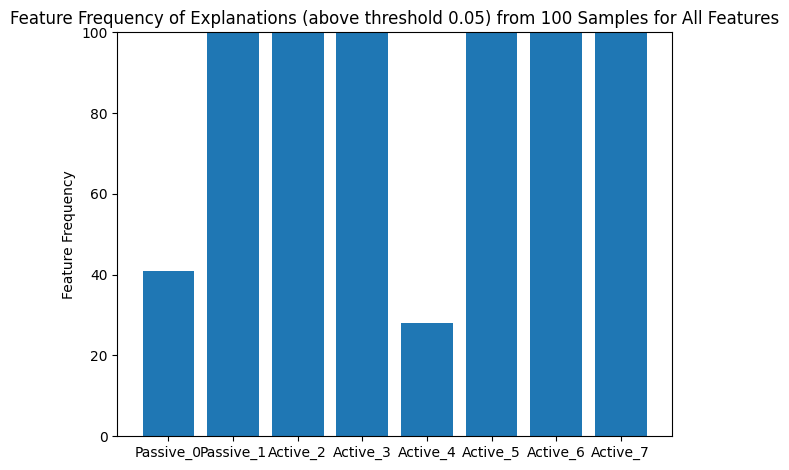

In [18]:
Reg_Stats.Frequency_Plot()


Average, SD, and Max Differences:
y - BB(x):           69.12242172906717  :  58.113375995458846  :  308.8573614073652
y - exp(x):          69.12242172658435  :  58.11337599786644  :  308.8573614068483
BB(x) - exp(x):      9.287658295775713e-09  :  3.8672674709856187e-08  :  3.638848582454557e-07
Average exp(x) Uncertainty:  1.0000000302679486e-05
R Score:   1.0
Fidelity:  1.0


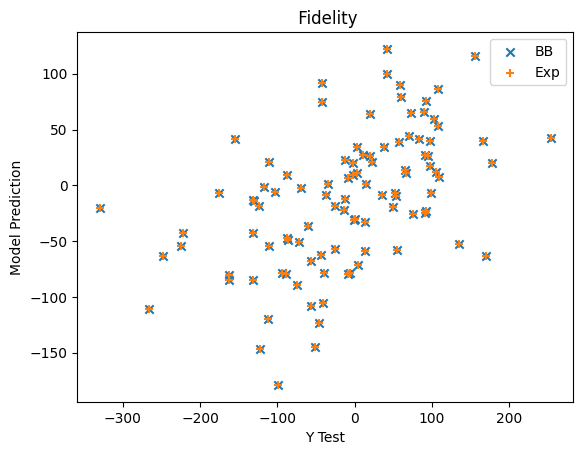

In [19]:
Reg_Stats.Fidelity()

In [20]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  0.9674747474747475
Mean Jaccard Distance:    0.032525252525252527


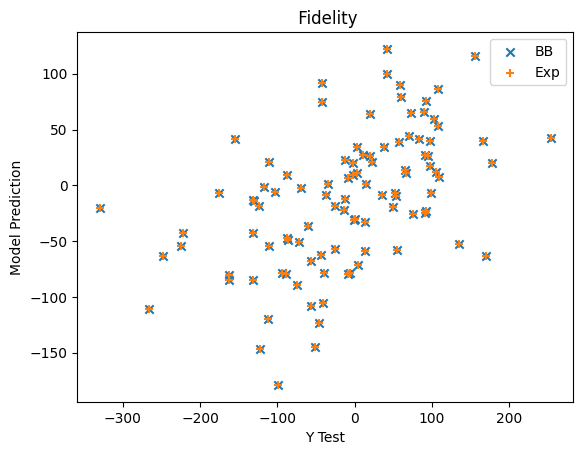

In [21]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (100, 8)


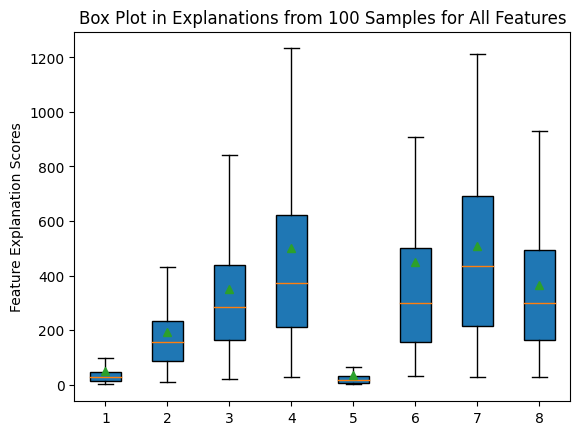

1 -      Passive_0
2 -      Passive_1
3 -      Active_2
4 -      Active_3
5 -      Active_4
6 -      Active_5
7 -      Active_6
8 -      Active_7


In [22]:
Reg_Stats.Box_Plot()


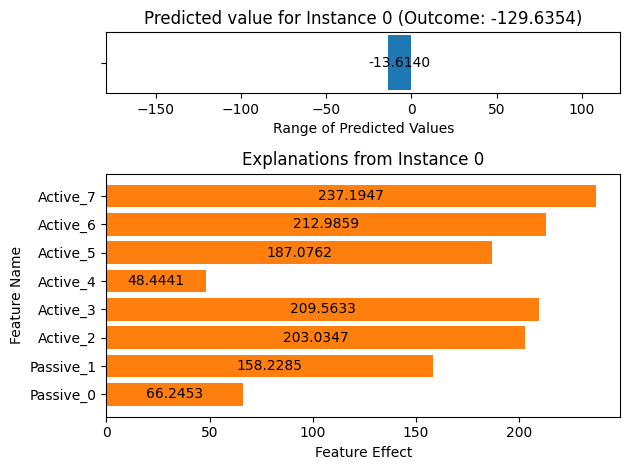

In [23]:
Reg_Stats.View_Explanation(instance = 0)

In [24]:
scores = URM_Exp.permutation_importance()
    
print(scores)

[  39.95511352  210.37176312  373.28878583 1665.33316529   24.39670509
  335.93999959  485.29145528  328.79006615]


In [25]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[ 4.68979559  4.9438531   6.19801226 13.67441413  4.6309896   5.45298121
  8.35970809  5.44941104]


In [26]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[ 18.52057116  21.97706559  66.860261   581.39397598  17.85755006
  42.32741472 188.26863674  61.05526648]


In [27]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[1.28614212 0.42316842 1.54874364 0.17799886 1.58779112 1.59240996
 1.36434338 0.01940249]


In [28]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

[2.31348273e-04 3.51711834e-03 4.85172993e-01 6.92033906e+00
 1.19972526e-04 1.00637196e-02 3.53684731e-01 2.26871059e-01]


In [29]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[-1.09753470e+05  1.66644326e+03  1.75457895e+01 -2.82829103e+01
  1.25923718e+05  2.53304521e+01 -5.02899673e+01 -3.87863987e+01]


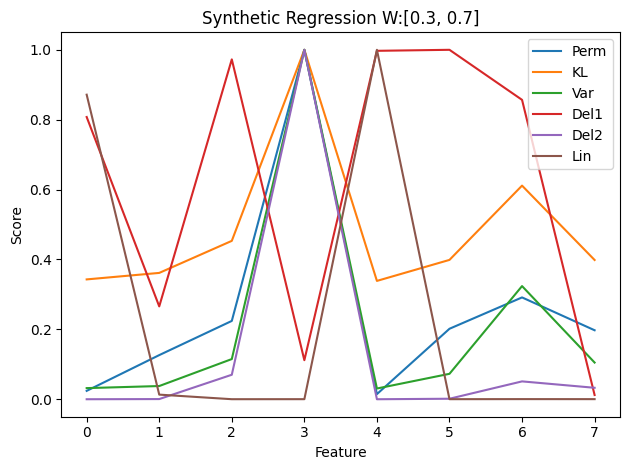

In [30]:
URM_Exp.plot_scores(Title)

In [31]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.40336605e-01  9.40303672e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.31503916e-01 -2.57297734e-02  9.90981684e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [32]:
acq_data.Create_BB_plot()

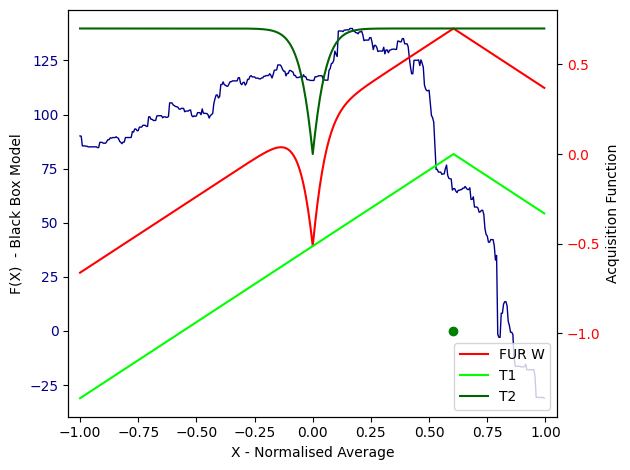

In [33]:
acq_data.plot_point(0)

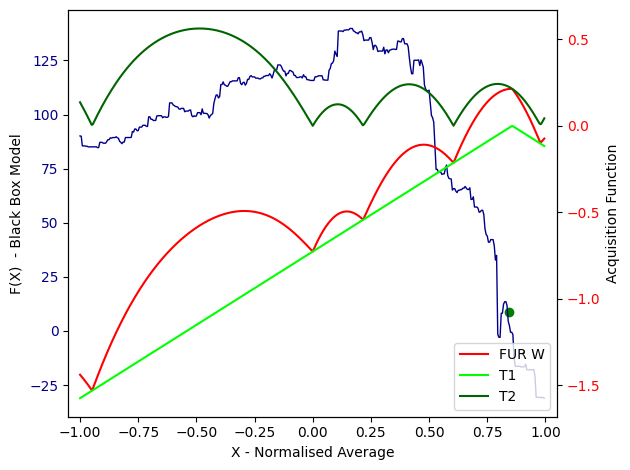

In [34]:
acq_data.plot_point(5)

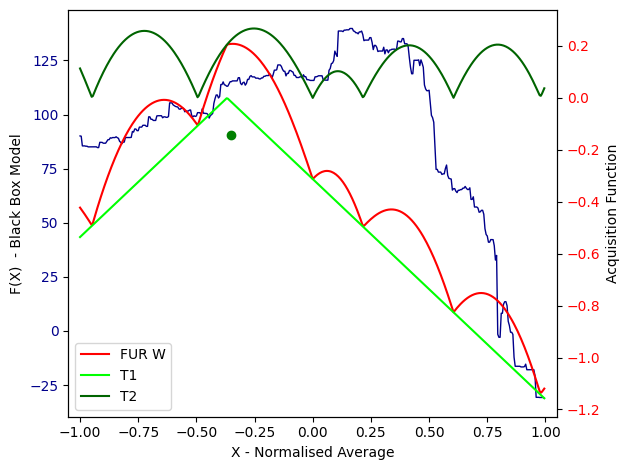

In [35]:
acq_data.plot_point(10)

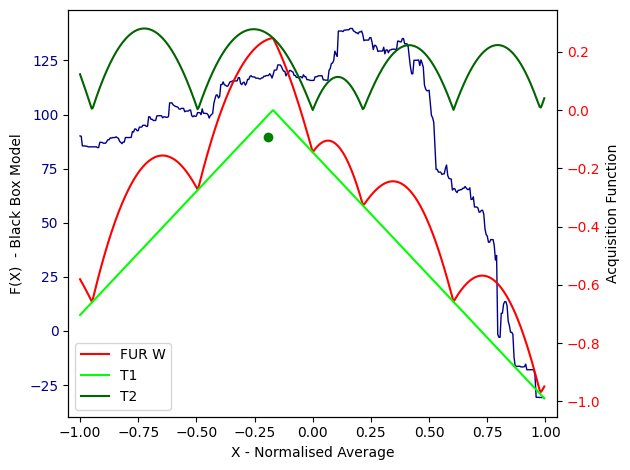

In [36]:
acq_data.plot_point(15)

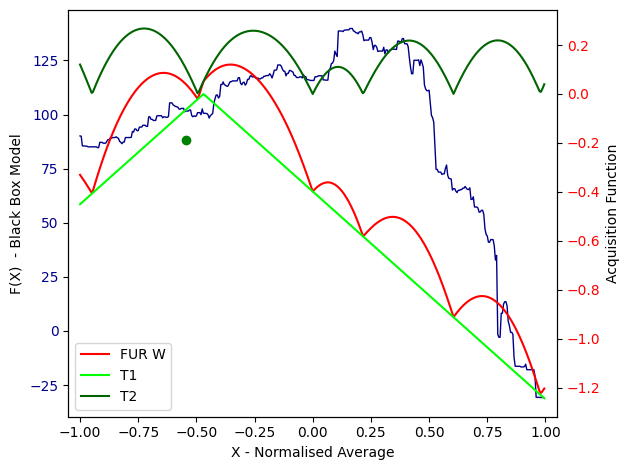

In [37]:
acq_data.plot_point(19)

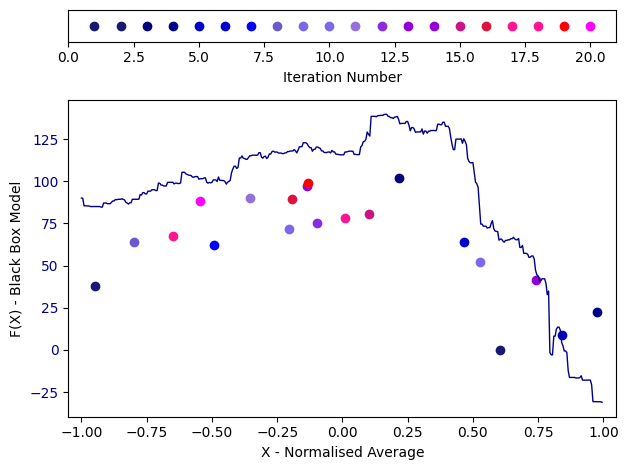

In [38]:
acq_data.plot_all()

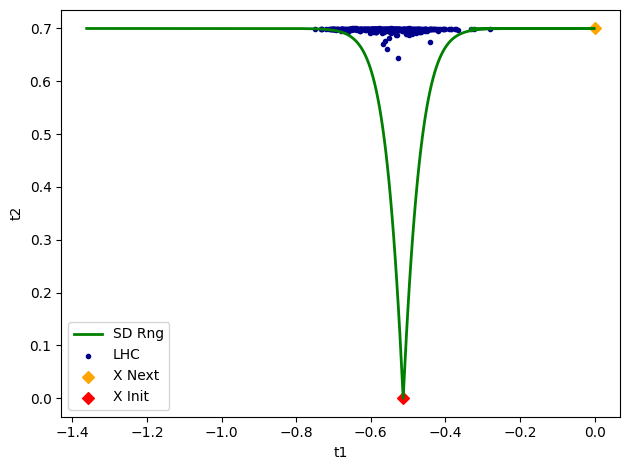

In [39]:
acq_data.plot_t1_t2(0)

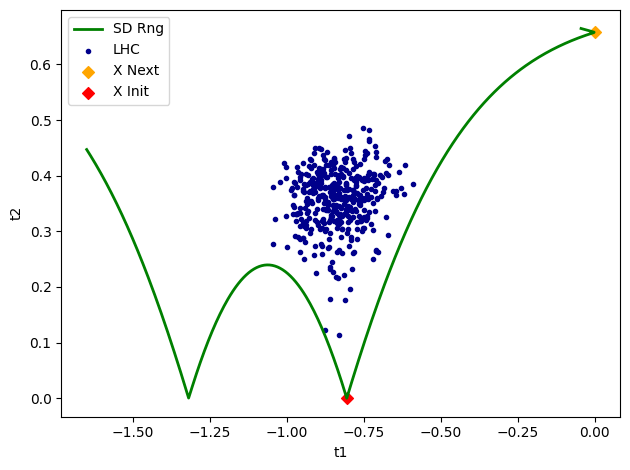

In [40]:
acq_data.plot_t1_t2(1)

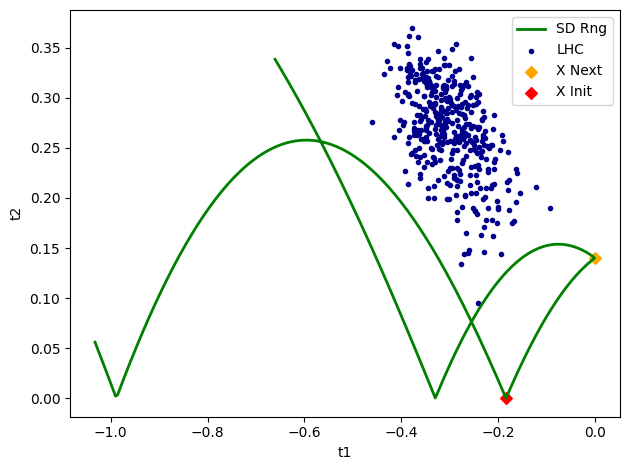

In [41]:
acq_data.plot_t1_t2(2)

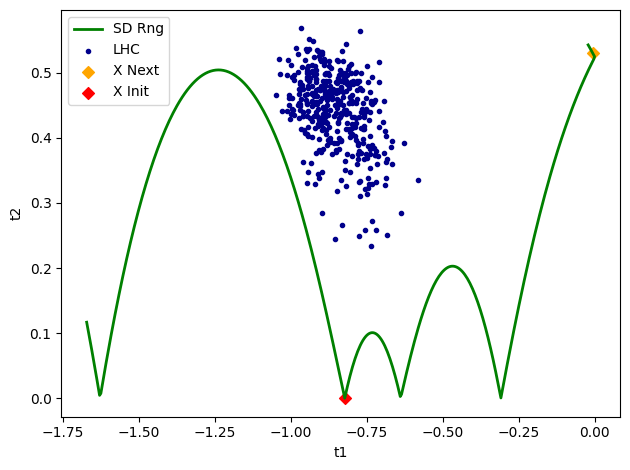

In [42]:
acq_data.plot_t1_t2(3)

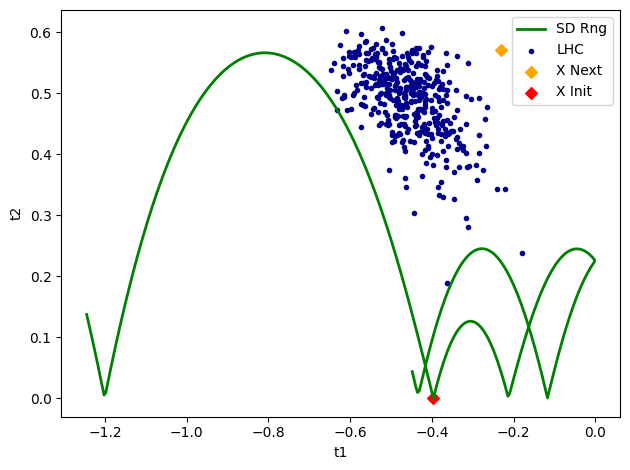

In [43]:
acq_data.plot_t1_t2(4)

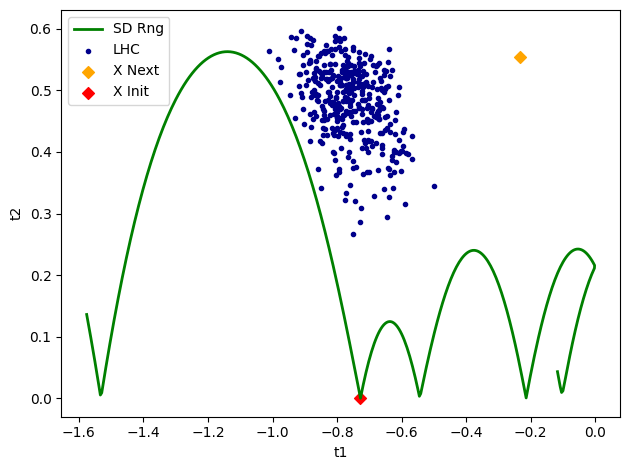

In [44]:
acq_data.plot_t1_t2(5)

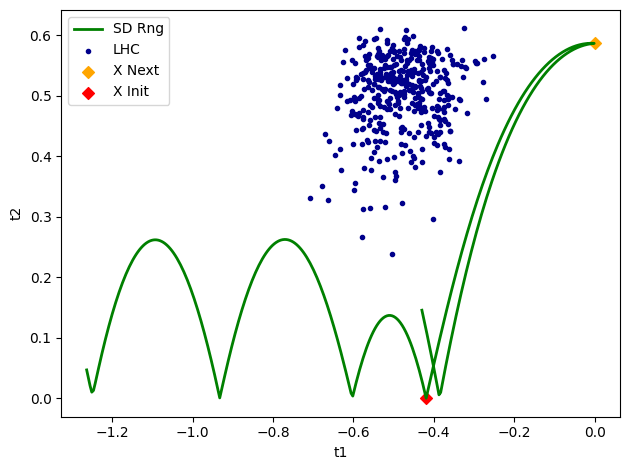

In [45]:
acq_data.plot_t1_t2(6)

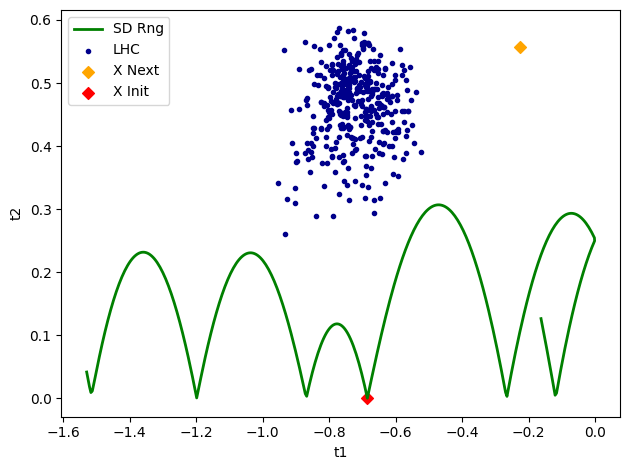

In [46]:
acq_data.plot_t1_t2(7)

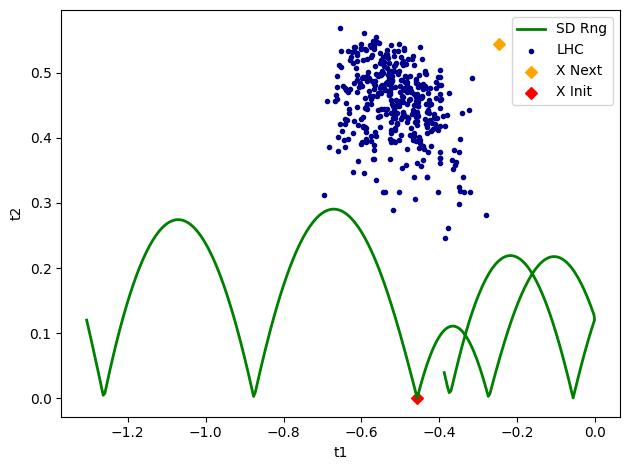

In [47]:
acq_data.plot_t1_t2(8)

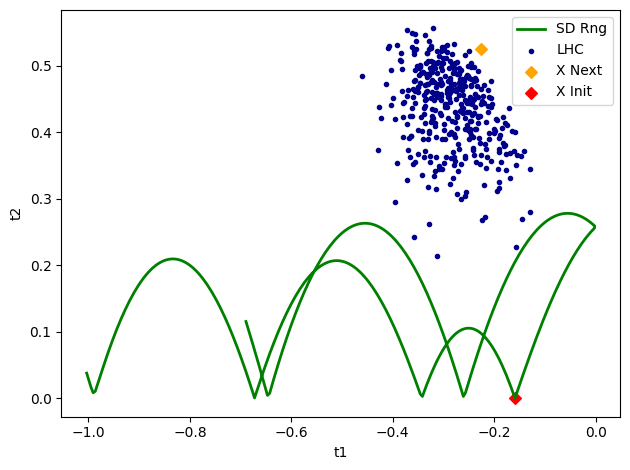

In [48]:
acq_data.plot_t1_t2(9)

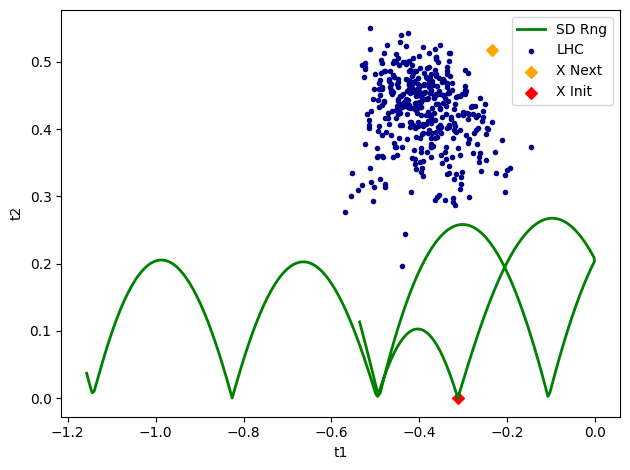

In [49]:
acq_data.plot_t1_t2(10)

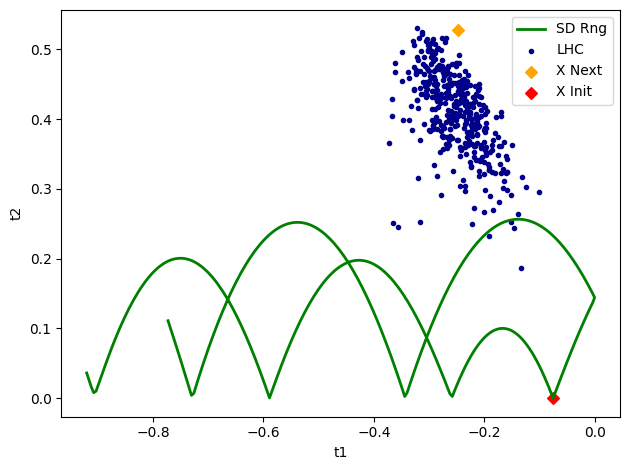

In [50]:
acq_data.plot_t1_t2(11)

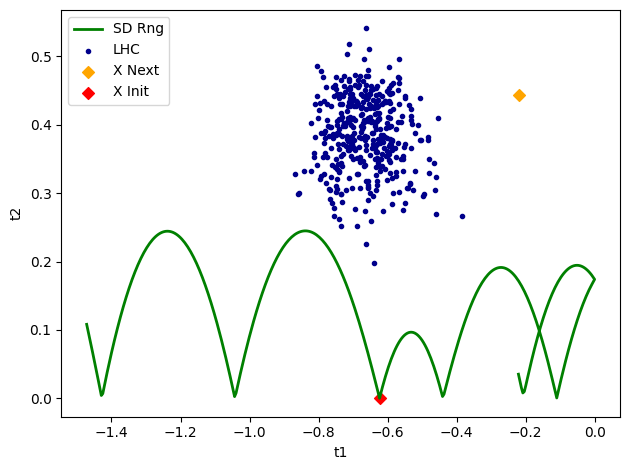

In [51]:
acq_data.plot_t1_t2(12)

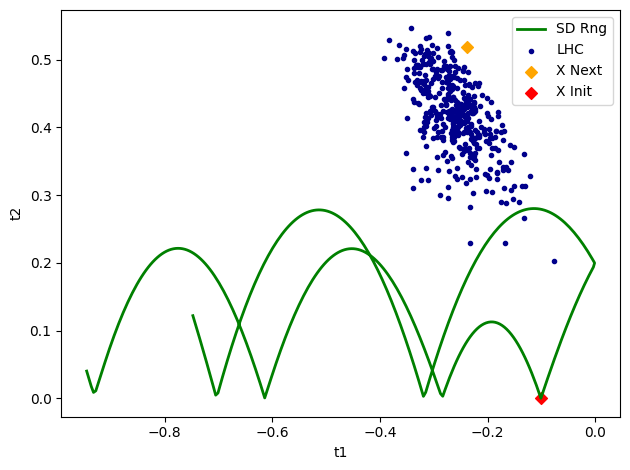

In [52]:
acq_data.plot_t1_t2(13)

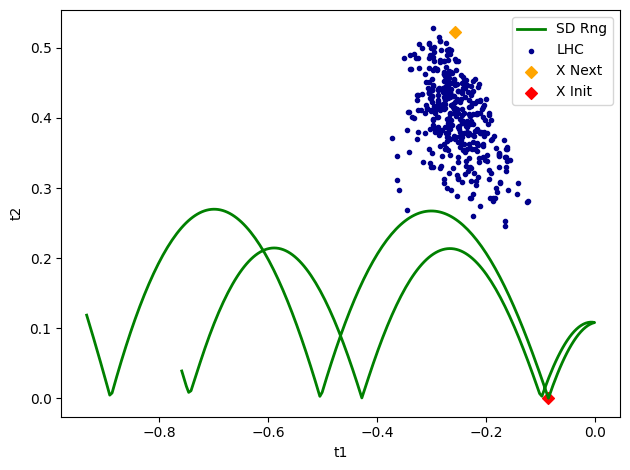

In [53]:
acq_data.plot_t1_t2(14)

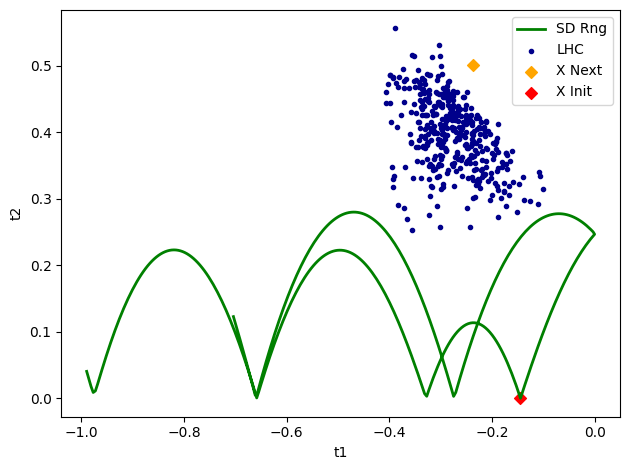

In [54]:
acq_data.plot_t1_t2(15)

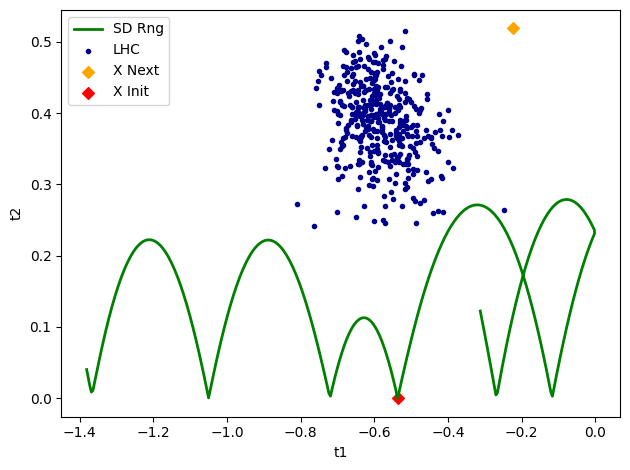

In [55]:
acq_data.plot_t1_t2(16)

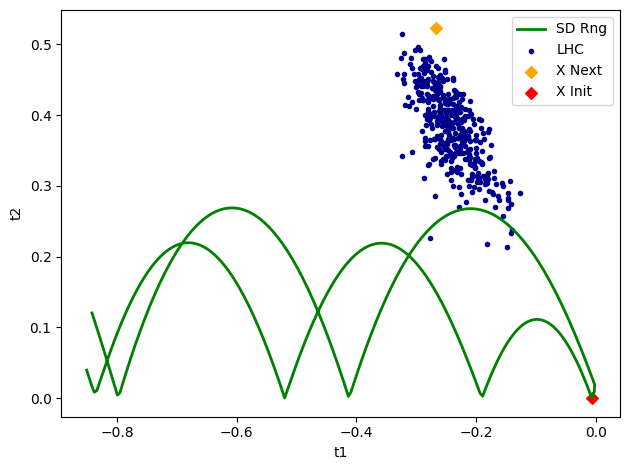

In [56]:
acq_data.plot_t1_t2(17)

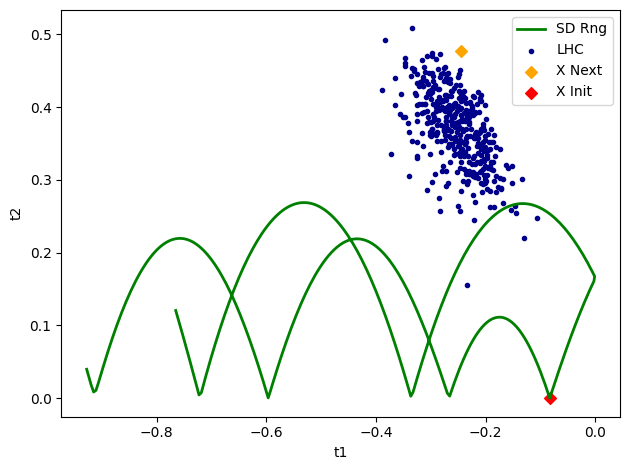

In [57]:
acq_data.plot_t1_t2(18)

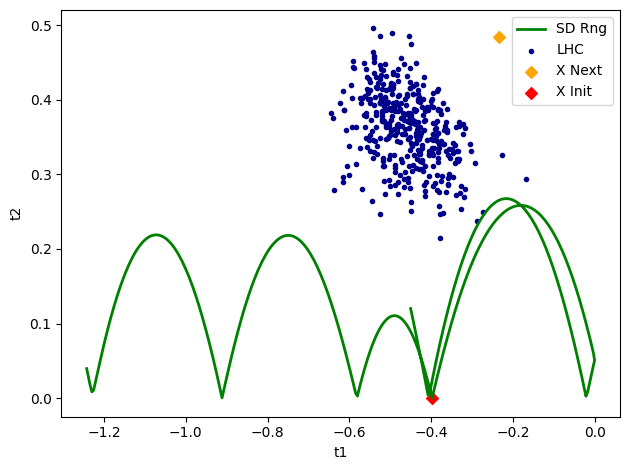

In [58]:
acq_data.plot_t1_t2(19)

Average, SD, and Max Differences:
y - BB(x):           69.12242172906717  :  58.113375995458846  :  308.8573614073652
y - exp(x):          69.12242172658435  :  58.11337599786644  :  308.8573614068483
BB(x) - exp(x):      9.287658295775713e-09  :  3.8672674709856187e-08  :  3.638848582454557e-07
Average exp(x) Uncertainty:  1.0000000302679486e-05
R Score:   1.0
Fidelity:  1.0


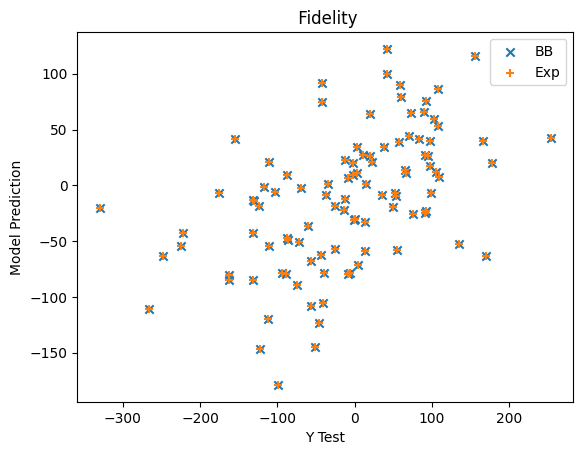

Fidelity:  0.9999999999291632


In [59]:
Reg_Stats.Fidelity()

print('Fidelity: ', Reg_Stats.fidelity)

In [60]:
Reg_Stats.Jaccard_Values(top_k=4)

print('Jaccard: ', Reg_Stats.jaccard_similarities)

Mean Jaccard Similarity:  0.6989898989898989
Mean Jaccard Distance:    0.30101010101010095
Jaccard:  0.6989898989898989


In [61]:
Reg_Stats.add_Feature_Coeffs(Feature_Coeffs = Reg_Data.get_Feature_Coeffs())
        
print('Coeff Ratio: ', Reg_Stats.coeffs_ratio)

Mean Coeffs Ratio:  [  0.           0.           5.16935697  -5.68977658 -41.20777125
   7.79723421   4.08781983  -1.94489309]
Feature Coeff Correlation:  0.28152748452852255
Coeff Ratio:  [  0.           0.           5.16935697  -5.68977658 -41.20777125
   7.79723421   4.08781983  -1.94489309]


In [62]:
delete_1_var = Reg_Stats.delete_one()


mean_variance [42.13193046 34.01039844 35.81665599 27.56063366 47.44000727 44.20170853
 45.33222093 33.08469731]
Mean scores: [ 48.19133222 191.26501899 349.88584176 501.32230441  33.55029092
 450.10061472 506.98163878 364.84606688]
sort_order [4 0 1 2 7 5 3 6]
norm sorted_scores [0.1097247  0.15760756 0.62552356 1.14428576 1.1932125  1.47203363
 1.63955184 1.65806044]
norm sorted_variance [1.22592609 1.08875685 0.8788834  0.92556    0.85496179 1.14224325
 0.7122111  1.17145751]
Prediction Variance Feature Deletion 1: [42.13193046 34.01039844 35.81665599 27.56063366 47.44000727 44.20170853
 45.33222093 33.08469731]
Delete 1 error: 0.5751776292039145
Delete 1 Correlation: -0.34086531532799086


N_Points:  25


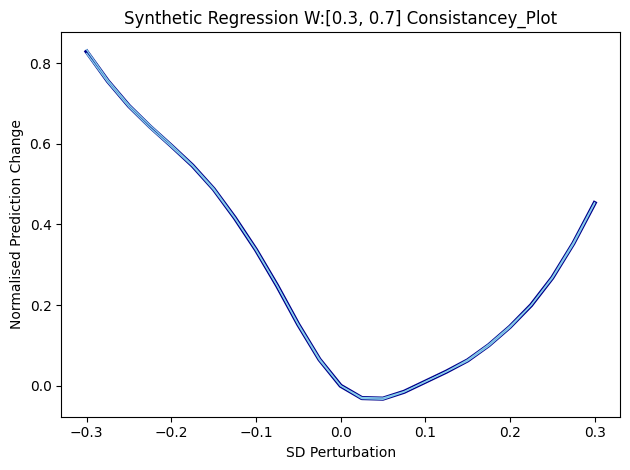

In [63]:
Reg_Stats.Consistancy(std_bound = consist_bound, plot=True, title = Title)

In [64]:
Reg_Stats.Compare_Models (model_b = Reg_Stats_2)

mean_scores:  [ 48.19133222 191.26501899 349.88584176 501.32230441  33.55029092
 450.10061472 506.98163878 364.84606688]
mean_scores_d:  [  4.31072566  31.18522218  79.81360901 310.86440801   2.54462553
 245.84907497 382.26500489  66.74734242]
Score Diff Mean:  [0.83578832 0.71962069 0.62851426 0.23450014 0.85900366 0.29348607
 0.14024977 0.69069341]
Score Diff SD:    [1.64839075 0.86419286 0.67990933 0.56110831 1.88029866 0.74790095
 0.43973206 0.66801266]
 Model Feature Correlation:  0.8693650178843335


Calibration MSE/MAE -1.3373670198533425 0.4805386458464418


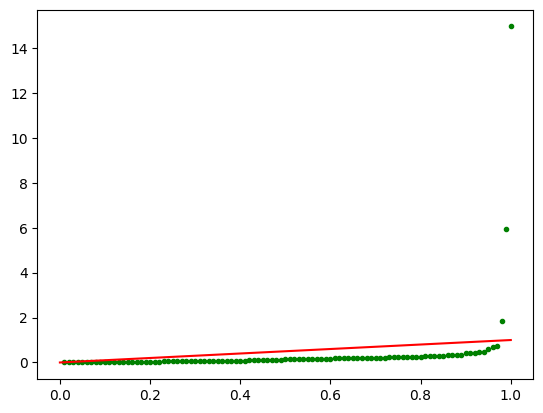

In [65]:
Reg_Stats.Regression_Calibration(plot=True, title=Title)

In [66]:
print(Reg_Stats.calibration_MAE)

0.4805386458464418


In [67]:
Reg_Stats.Regression_Calibration_2(plot=True, title=Title)

root_mean_squared_calibration_error:  0.5695874961978323
mean_absolute_calibration_error:  0.48969999999999997


In [68]:
Reg_Stats.delete_one()

mean_variance [42.13193046 34.01039844 35.81665599 27.56063366 47.44000727 44.20170853
 45.33222093 33.08469731]
Mean scores: [ 48.19133222 191.26501899 349.88584176 501.32230441  33.55029092
 450.10061472 506.98163878 364.84606688]
sort_order [4 0 1 2 7 5 3 6]
norm sorted_scores [0.1097247  0.15760756 0.62552356 1.14428576 1.1932125  1.47203363
 1.63955184 1.65806044]
norm sorted_variance [1.22592609 1.08875685 0.8788834  0.92556    0.85496179 1.14224325
 0.7122111  1.17145751]
Prediction Variance Feature Deletion 1: [42.13193046 34.01039844 35.81665599 27.56063366 47.44000727 44.20170853
 45.33222093 33.08469731]
Delete 1 error: 0.5751776292039145
Delete 1 Correlation: -0.34086531532799086


In [69]:
Reg_Stats.Results_Summary(Title)

Results_Summary: Synthetic Regression W:[0.3, 0.7]
Timestamp:  2023-05-11 12:27:07.269856
 Model Feature Correlation:  0.8693650178843335
R Score:   1.0
Fidelity:  1.0
Consistancey Std/Y Pert:  0.3 : 0.6406934807483449
Delete 1 error:       0.5751776292039145
Delete 1 Correlation: -0.34086531532799086
Mean Jaccard Similarity:  0.6989898989898989
Mean Jaccard Distance:    0.30101010101010095
Calibration MSE/MAE:  -1.3373670198533425 : 0.4805386458464418
 Model Feature Correlation:  0.8693650178843335
Mean Coeffs Error:  0.28152748452852255
